In [82]:
using PyCall,TickTock


scipy = pyimport("scipy")
scipyinterpolate = pyimport("scipy.interpolate")

#psi(x) = scipyinterpolate.splev(x, spl)
#b=psi(initX)
tick()
psi_func = scipyinterpolate.splrep(initX1, state_array[4:L-3,3],k=4)
data=(scipyinterpolate.splev(initX1, psi_func))
tock()
#a.-b

tick()
psi_func=Spline1D(initX1, state_array[4:L-3,3],  k=4);
b=psi_func(initX1)
tock()
a.-b;

[ Info:  started timer at: 2023-06-02T10:32:19.444
[ Info:          0.008718292s: 8 milliseconds
[ Info:  started timer at: 2023-06-02T10:32:19.453
[ Info:          0.002346985s: 2 milliseconds


# Evolution of Einstein's equations

# Initial data , setting length of the domain and discretization


# Parameters

In [142]:
m = 1
A = 0.0492645084166179#0.049264507293701174#0.049264508247375494#0.04925#0.0493#0.001#0.049375#0.07#0.05#0.1124921875#0.125
run = 1

1

In [143]:
global bisection=false

false

In [144]:
res=m;
N=2.0^m*4000.0/2.0
Xf=1.0;

dx=Xf/N;
dt=0.5*round(dx,digits=10);
Nt=2.0^m*4000.0/2.0
Tf=Nt*dt; #final time
print(Tf)

0.5

In [145]:
print(N)

4000.0

In [146]:
println("dx =", dx)
println("dt =", dt)
println("dx/dt =", dx/dt)

dx =0.00025
dt =0.000125
dx/dt =2.0


In [147]:
global dir = "/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA"
#global dir = "/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA"

"/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA"

# Grid

In [148]:
using Printf
include("./ScalarField.jl");

In [149]:
ori=0.0;
initX1 = nothing
N=int(N)
initX1=range(ori, stop=Xf, step=dx);

initX = range(round(ori-3.0*dx,digits=10), stop=Xf+3.0*dx, step=dx)

L=length(initX);
println("step size is  ", dx)
println("the time step is ", dt)

step size is  0.00025
the time step is 0.000125


In [150]:
"""if m==1
    initX1=chebyshev(int((L-6)))
    L1=L;
elseif m==2
    initX1=doublegrid(chebyshev(int((L1-6))))
else
    initX1=doublegrid(doublegrid(chebyshev(int((L1-6)))))
end
initX=collect(initX)
initX[4:L-3]=initX1;""";

# Initial data of m β Ψ and Ψ,x

In [151]:
using Dierckx
using Quadmath


####
#initm=Array{Float128}(undef, L)
#initbeta=Array{Float128}(undef, L)
#initpsi=Array{Float128}(undef, L)
#initderpsi=Array{Float128}(undef, L)
initm=zeros(L);
initbeta=zeros(L);
initpsi=zeros(L);
initderpsi=zeros(L);

state_array=[initm initbeta initpsi initderpsi initX];

#PSI
r0=0.7#0.01#0.7#0.01#0.7#0.7#0.7#0.01#0.7#0.3
sigma=0.3
initpsi[4:L-3] = init_gaussian(initX1,r0,sigma,A)

state_array[:,3] = initpsi
state_array = ghost(state_array)

#PSI,X FROM PSI
initderpsi[4:L-3] = init_gaussian_der(initX1,r0,sigma,A)
state_array[:,4] = initderpsi
state_array=ghost(state_array)

####

derpsi_func = Spline1D(initX[4:L-3], state_array[4:L-3,4],  k=4);

In [152]:
##AUX
auxinitm=zeros((L-6)*2+5);
auxinitbeta=zeros((L-6)*2+5);
auxinitpsi=zeros((L-6)*2+5);
auxinitderpsi=zeros((L-6)*2+5);
auxinitX=range(round(ori-3.0*dx/2,digits=10), stop=Xf+3.0*dx/2, step=dx/2)
auxinitX1=auxinitX[4:length(auxinitX)-3]
auxL=length(auxinitX)

auxstate_array=[auxinitm auxinitbeta auxinitpsi auxinitderpsi auxinitX];

#PSI
r0=0.7
sigma=0.3
auxinitpsi[4:auxL-3] = init_gaussian(auxinitX1,r0,sigma,A)

auxstate_array[:,3] = auxinitpsi
auxstate_array = ghost(auxstate_array)

#PSI,X FROM PSI
auxinitderpsi[4:auxL-3] = init_gaussian_der(auxinitX1,r0,sigma,A)
auxstate_array[:,4] = auxinitderpsi
auxstate_array=ghost(auxstate_array)

####

auxderpsi_func = Spline1D(auxinitX[4:auxL-3], auxstate_array[4:auxL-3,4],  k=4);

In [153]:
"""integ=integrator(initX,derpsi_func)
plot(initX1, integ[4:L-3],xlim=[0,0.001])"""

"integ=integrator(initX,derpsi_func)\nplot(initX1, integ[4:L-3],xlim=[0,0.001])"

In [154]:
##AUX
y0=[0 0 0]
auxstate_array[4:auxL-3,1:3] = n_rk4wrapper(RHS,y0,auxinitX[4:auxL-3],0,auxderpsi_func,auxstate_array[:,:]);

In [155]:
y0=[0 0 0]
#state_array[4:L-3,1:3] = n_rk4wrapper(RHS,y0,initX[4:L-3],0,derpsi_func,state_array[:,:],auxstate_array); #ghost grid

state_array[4:L-3,1:3] = n_rk4wrapper(RHS,y0,initX[4:L-3],0,derpsi_func,state_array[:,:]);

state_array = ghost(state_array);

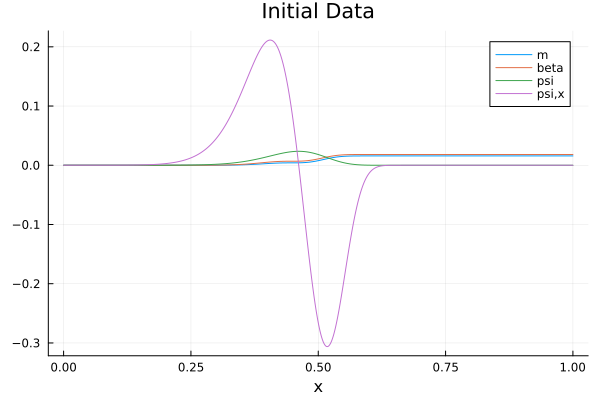

In [156]:
using Plots #showing initial data and the initial status of the horizon finder
plot(initX[4:L-3], state_array[4:L-3,1:4], xaxis="x",title="Initial Data", labels=["m" "beta" "psi" "psi,x"])

# Defining the initial state array for the evolution m β Ψ and Ψ,x

In [157]:
using CSV, Tables, Printf
#CSV.write(dir*"/time_step0.csv", Tables.table(transpose(Matrix(state_array))), writeheader=false)
CSV.write(dir*"/res$res/time_step0.csv", Tables.table(state_array), writeheader=false)

global files=["m", "beta", "psi", "derpsi"]

print_muninn(files, 0, state_array[:,1:5],res,"w")

In [158]:
time=0.0
criticality=0.0
explode=0.0
evol_stats = [criticality A sigma r0 time explode run]
monitor_ratio = zeros(L)
CSV.write(dir*"/parameters.csv", Tables.table(evol_stats), writeheader=true, header=["criticality", "A", "sigma", "r0", "time", "explode", "run"])

"/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/parameters.csv"

In [159]:
ginit=speed(initX,state_array[:,1],state_array[:,2],dx)
println(update_dt(initX,state_array[:,1],state_array[:,2],dx,ginit)/dt)

2.0010003751250394


In [160]:
using Base.Threads
Threads.nthreads()

4

 ## Time evolution

fixed grid

In [161]:
finaltime=1.6#2#1.3#0.08*2#0.005*10*5#1#0.9#0.8#0.04*5*4#length(T)-1
evol_stats, T_interp = timeevolution(state_array,finaltime,dir*"/res$res",run);#timeevolution(state_array,finaltime,dir*"/res$res",run,auxstate_array);
CSV.write(dir*"/timearray$res.csv", Tables.table(T_interp), writeheader=false);
#CSV.write(dir*"/parameters.csv", Tables.table(evol_stats), writeheader=false);



iteration 10 dt is 0.0002501250468906299, t=0.0025012504689062988 speed is 0.49975003124999995, dx/dt=0.9995000624999999


iteration 20 dt is 0.0002501250468906299, t=0.005002500937812597 speed is 0.49975003124999995, dx/dt=0.9995000624999999


iteration 30 dt is 0.0002501250468906299, t=0.007503751406718894 speed is 0.49975003124999995, dx/dt=0.9995000624999999


iteration 40 dt is 0.0002501250468906299, t=0.010005001875625199 speed is 0.49975003124999995, dx/dt=0.9995000624999999


iteration 50 dt is 0.0002501250468906299, t=0.012506252344531505 speed is 0.49975003124999995, dx/dt=0.9995000624999999


iteration 60 dt is 0.0002501250468906299, t=0.01500750281343781 speed is 0.49975003124999995, dx/dt=0.9995000624999999


iteration 70 dt is 0.0002501250468906299, t=0.017508753282344115 speed is 0.49975003124999995, dx/dt=0.9995000624999999


iteration 80 dt is 0.0002501250468906299, t=0.02001000375125042 speed is 0.49975003124999995, dx/dt=0.9995000624999999


iteration 90 dt is 0.00



iteration 690 dt is 0.0002501250468905798, t=0.17258628235453055 speed is 0.49975003125010004, dx/dt=0.9995000625002001


iteration 700 dt is 0.0002501250468905745, t=0.17508753282343625 speed is 0.49975003125011064, dx/dt=0.9995000625002213


iteration 710 dt is 0.0002501250468905686, t=0.1775887832923419 speed is 0.49975003125012246, dx/dt=0.9995000625002449


iteration 720 dt is 0.00025012504689056215, t=0.18009003376124755 speed is 0.49975003125013534, dx/dt=0.9995000625002707


iteration 730 dt is 0.000250125046890555, t=0.1825912842301532 speed is 0.49975003125014966, dx/dt=0.9995000625002993


iteration 740 dt is 0.00025012504689054713, t=0.1850925346990587 speed is 0.4997500312501653, dx/dt=0.9995000625003307


iteration 750 dt is 0.00025012504689053846, t=0.18759378516796407 speed is 0.49975003125018264, dx/dt=0.9995000625003654


iteration 760 dt is 0.00025012504689052897, t=0.19009503563686944 speed is 0.4997500312502016, dx/dt=0.9995000625004032


iteration 770 dt is 0.00



iteration 1370 dt is 0.00025012504686954077, t=0.34267131423758285 speed is 0.4997500312921361, dx/dt=0.9995000625842722


iteration 1380 dt is 0.0002501250468678095, t=0.3451725647062689 speed is 0.4997500312955951, dx/dt=0.9995000625911903


iteration 1390 dt is 0.00025012504686594214, t=0.3476738151749368 speed is 0.49975003129932616, dx/dt=0.9995000625986523


iteration 1400 dt is 0.00025012504686392823, t=0.3501750656435852 speed is 0.49975003130334994, dx/dt=0.9995000626066999


iteration 1410 dt is 0.00025012504686175706, t=0.35267631611221273 speed is 0.49975003130768797, dx/dt=0.9995000626153758


iteration 1420 dt is 0.0002501250468594167, t=0.3551775665808175 speed is 0.499750031312364, dx/dt=0.9995000626247279


iteration 1430 dt is 0.00025012504685689485, t=0.357678817049398 speed is 0.49975003131740264, dx/dt=0.9995000626348053


iteration 1440 dt is 0.0002501250468541779, t=0.3601800675179522 speed is 0.49975003132283113, dx/dt=0.9995000626456623


iteration 1450 dt is



iteration 2050 dt is 0.00025012504433003733, t=0.5127563457331431 speed is 0.49975003636606585, dx/dt=0.9995000727321318


iteration 2060 dt is 0.00025012504416891735, t=0.5152575961755648 speed is 0.4997500366879838, dx/dt=0.9995000733759675


iteration 2070 dt is 0.0002501250439986134, t=0.517758846616325 speed is 0.4997500370282511, dx/dt=0.9995000740565023


iteration 2080 dt is 0.00025012504381867755, t=0.5202600970553296 speed is 0.4997500373877632, dx/dt=0.9995000747755263


iteration 2090 dt is 0.0002501250436286454, t=0.5227613474924797 speed is 0.4997500377674475, dx/dt=0.999500075534895


iteration 2100 dt is 0.0002501250434280371, t=0.5252625979276717 speed is 0.499750038168263, dx/dt=0.999500076336526


iteration 2110 dt is 0.0002501250432163566, t=0.5277638483607973 speed is 0.4997500385912008, dx/dt=0.9995000771824017


iteration 2120 dt is 0.00025012504299309196, t=0.5302650987917426 speed is 0.49975003903728377, dx/dt=0.9995000780745676


iteration 2130 dt is 0.00025



iteration 2730 dt is 0.0002501249894839434, t=0.682841362982751 speed is 0.49975014594862893, dx/dt=0.999500291897258


iteration 2740 dt is 0.0002501249882222006, t=0.6853426128706173 speed is 0.49975014846959326, dx/dt=0.9995002969391865


iteration 2750 dt is 0.00025012498700423865, t=0.6878438627461017 speed is 0.4997501509030833, dx/dt=0.9995003018061664


iteration 2760 dt is 0.0002501249858367201, t=0.6903451126096782 speed is 0.4997501532357873, dx/dt=0.9995003064715746


iteration 2770 dt is 0.0002501249847266152, t=0.6928463624618894 speed is 0.4997501554537788, dx/dt=0.9995003109075576


iteration 2780 dt is 0.00025012498368118794, t=0.6953476123033493 speed is 0.4997501575425443, dx/dt=0.9995003150850886


iteration 2790 dt is 0.0002501249827079788, t=0.6978488621347457 speed is 0.49975015948701795, dx/dt=0.9995003189740358


iteration 2800 dt is 0.00025012498181478193, t=0.7003501119568435 speed is 0.49975016127162686, dx/dt=0.9995003225432537


iteration 2810 dt is 0.00



iteration 3410 dt is 0.00021045030423230804, t=0.8466773114709771 speed is 0.5939644537744041, dx/dt=1.1879289075488082


iteration 3420 dt is 0.00020962691861937163, t=0.8487772560585866 speed is 0.5962974641962263, dx/dt=1.1925949283924526


iteration 3430 dt is 0.0002088390903465517, t=0.8508691635505526 speed is 0.598546947281625, dx/dt=1.19709389456325


iteration 3440 dt is 0.00020808529265407006, t=0.8529533812876299 speed is 0.6007152086803433, dx/dt=1.2014304173606867


iteration 3450 dt is 0.0002073639148032202, t=0.8550302407018382 speed is 0.6028049775131794, dx/dt=1.2056099550263588


iteration 3460 dt is 0.00020667313206695524, t=0.8571000560713372 speed is 0.6048197883772534, dx/dt=1.2096395767545067


iteration 3470 dt is 0.00020601111613682005, t=0.8591631233559609 speed is 0.6067633744432636, dx/dt=1.2135267488865271


iteration 3480 dt is 0.0002053757270948288, t=0.8612197185219506 speed is 0.6086405719322583, dx/dt=1.2172811438645166


iteration 3490 dt is 0.00020



iteration 4090 dt is 0.00010555019913496137, t=0.9651114597261559 speed is 1.184270622172576, dx/dt=2.368541244345152


iteration 4100 dt is 0.00010329536143003533, t=0.9661544843130719 speed is 1.2101221029626368, dx/dt=2.4202442059252736


iteration 4110 dt is 0.0001011362129374879, t=0.9671754804216497 speed is 1.2359568978251367, dx/dt=2.4719137956502735


iteration 4120 dt is 9.908023037273461e-5, t=0.9681754462582265 speed is 1.2616038490196944, dx/dt=2.5232076980393887


iteration 4130 dt is 9.713481797393462e-5, t=0.9691554544400361 speed is 1.2868712023894746, dx/dt=2.5737424047789492


iteration 4140 dt is 9.530728113056783e-5, t=0.9701166510088377 speed is 1.3115472240652226, dx/dt=2.6230944481304452


iteration 4150 dt is 9.360479187257991e-5, t=0.9710602540738006 speed is 1.3354017192854508, dx/dt=2.6708034385709016


iteration 4160 dt is 9.203420623057437e-5, t=0.9719875520615001 speed is 1.3581906675745758, dx/dt=2.7163813351491517


iteration 4170 dt is 9.060233114702



iteration 4780 dt is 0.00012712973239350426, t=1.028696347441552 speed is 0.9832475664550908, dx/dt=1.9664951329101816


iteration 4790 dt is 9.425726369262289e-5, t=1.0298114171472814 speed is 1.3261577421516344, dx/dt=2.652315484303269


iteration 4800 dt is 0.00016939153157914202, t=1.0310883043395191 speed is 0.7379353550599329, dx/dt=1.4758707101198658


iteration 4810 dt is 9.945255645366809e-5, t=1.032290000386616 speed is 1.2568807123448222, dx/dt=2.5137614246896445


iteration 4820 dt is 0.00020033847082329568, t=1.0338578400213971 speed is 0.6239440656919739, dx/dt=1.2478881313839478


iteration 4830 dt is 0.0002490051460348088, t=1.0360955901642008 speed is 0.5019976574400838, dx/dt=1.0039953148801677


iteration 4840 dt is 0.00025012177137274873, t=1.0385897894597913 speed is 0.49975657582288735, dx/dt=0.9995131516457748


iteration 4850 dt is 0.0002501242376166738, t=1.0410909065681628 speed is 0.4997516481852027, dx/dt=0.9995032963704054


iteration 4860 dt is 0.0002501



iteration 5460 dt is 0.000250125046881118, t=1.1936671756722714 speed is 0.4997500312690048, dx/dt=0.9995000625380096


iteration 5470 dt is 0.00025012504688147973, t=1.1961684261410843 speed is 0.499750031268282, dx/dt=0.9995000625365641


iteration 5480 dt is 0.00025012504688182836, t=1.1986696766099012 speed is 0.4997500312675855, dx/dt=0.999500062535171


iteration 5490 dt is 0.00025012504688216413, t=1.2011709270787212 speed is 0.4997500312669146, dx/dt=0.9995000625338292


iteration 5500 dt is 0.00025012504688248744, t=1.2036721775475447 speed is 0.4997500312662686, dx/dt=0.9995000625325372


iteration 5510 dt is 0.0002501250468827987, t=1.2061734280163712 speed is 0.4997500312656467, dx/dt=0.9995000625312934


iteration 5520 dt is 0.0002501250468830982, t=1.208674678485201 speed is 0.49975003126504836, dx/dt=0.9995000625300967


iteration 5530 dt is 0.0002501250468833863, t=1.2111759289540336 speed is 0.49975003126447265, dx/dt=0.9995000625289454


iteration 5540 dt is 0.00025

 ## Movie of the evolution

[ Info: Saved animation to /home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/anim_res1.gif


Plots.AnimatedGif("/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/anim_res1.gif")
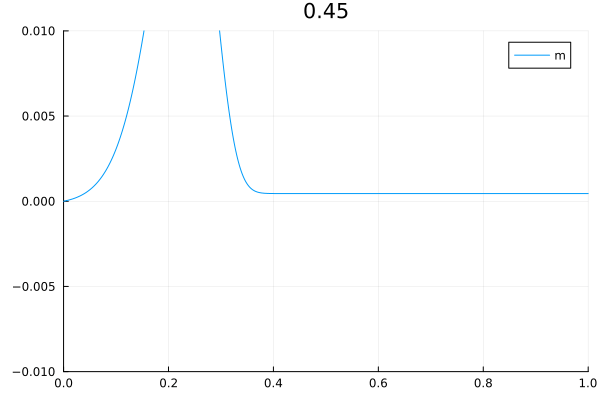

In [168]:
using Plots, CSV, DataFrames
import GR
anim = @animate for n in 1800:10:5880#870
    
    
    IJulia.clear_output(true)
    
    functions3=DataFrame(CSV.File(dir*"/res$res/time_step$n.csv",header=false, delim=","))
    
    #functions3=DataFrame(CSV.File("/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/bisectionsearch/run1"*"/time_step$n.csv",header=false, delim=","))
    plot()
        plot1=functions3.Column1[4:L-3];
        plot2=functions3.Column2[4:L-3];
        plot3=functions3.Column3[4:L-3];
        plot4=functions3.Column4[4:L-3];
        plot5=functions3.Column5[4:L-3];
    temp=round(n*dt,digits=2)
    plot!(initX1, [plot3], labels=["m" "beta" "psi" "psi,x"], title="$temp", ylim=[-0.01, 0.01],xlim=[0, 1])#, xlim=[0, 0.1])# |> display 
    #plot!(initX[4:L-3], [plot1], labels=["m" "beta" "psi" "psi,x"],ylim=[-1,1])#, xlim=[0, 0.1]) |> display 
    
    end

gif(anim, "anim_res$res.gif", fps = 10)

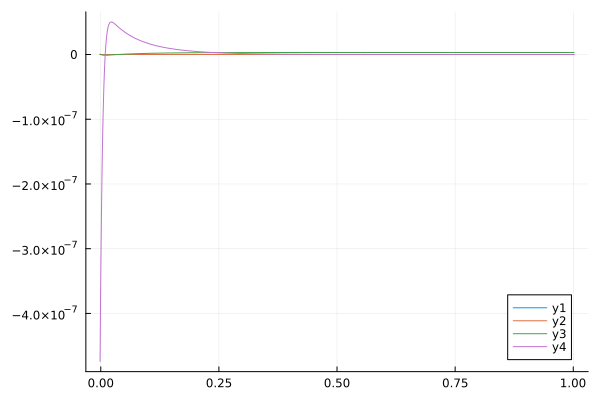

In [50]:
plot(initX, state_array[:,1:4])

In [115]:
using Plots, CSV, DataFrames
import GR
anim = @animate for n in 10:10:1000#length(T)-1
    
    IJulia.clear_output(true)
    
    functions3=DataFrame(CSV.File(dir*"/res$res/monitor_ratio$n.csv",header=false, delim=","))
    plot()
        plot1=functions3.Column1[4:L-3];
    
    plot!(initX1, [plot1], labels=["monitor ratio"], ylim=[0, 1])# |> display 
    #plot!(initX[4:L-3], [plot1], labels=["m" "beta" "psi" "psi,x"],ylim=[-1,1])#, xlim=[0, 0.1]) |> display 
    
    end

gif(anim, "anim_res$res.gif", fps = 5)

LoadError: ArgumentError: "/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/res2/monitor_ratio10.csv" is not a valid file or doesn't exist

In [208]:
epsilon(dx,dt)

0.015625

In [316]:
dt

0.001

0.0078125

In [31]:
state_array[:,4]

207-element Vector{Float64}:
 -2.365518250288725e-9
 -9.136367842295702e-10
 -2.14954583648039e-10
  0.0
  6.986152586784135e-13
  5.661291067212787e-11
  4.3721453478448e-10
  1.681826439904089e-9
  4.6038562839992895e-9
  1.0296050405382373e-8
  2.0137407051887777e-8
  3.5801665455811194e-8
  5.926726083699171e-8
  ⋮
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0

In [37]:

auxinitX= range(0,1,step=dx)
println(Der(state_array,6,4,auxinitX))

spl= Spline1D(initX[4:L-3], state_array[4:L-3,4],  k=4);
println(derivative(spl, auxinitX[6]))

3.017168193837207e-8
0.00017208804225226937


In [53]:
println(Der(state_array,60,4,initX))

spl= Spline1D(initX[4:L-3], state_array[4:L-3,4],  k=4);
println(derivative(spl, initX[60]))

println(derivative(spl, initX[60]).-Der(state_array,60,4,initX))

0.014407887381376435
0.014407810796996974
-7.658437946138352e-8


In [30]:
using Roots
find_zero(derpsi_func, (0,0.5), Bisection())

0.2713799770174635

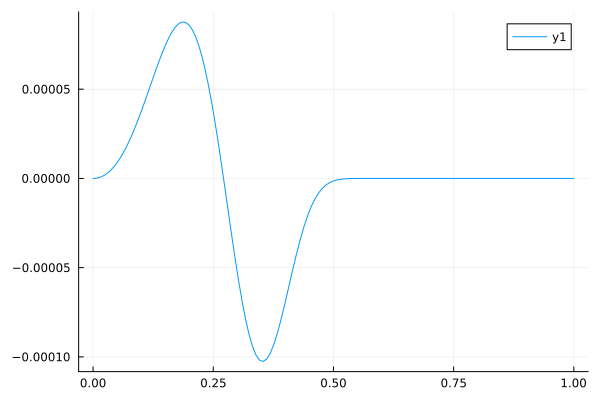

In [23]:
using Plots
plot(initX1, derpsi_func(initX1))

In [66]:
m_func = Spline1D(initX[4:L-3],state_array[4:L-3,1],k=4)
beta_func = Spline1D(initX[4:L-3],state_array[4:L-3,2],k=4)
der_funcs=[derivative(m_func,initX) derivative(beta_func,initX) derivative(derpsi_func,initX)]
der_funcs[2,1] # i is gridpoint, j is function

-1.5086563198078306e-16

In [58]:
derivative(m_func,initX)

207-element Vector{Float64}:
 -3.6298572062043756e-16
 -1.5086563198078306e-16
 -4.2846357130174216e-17
 -3.826449677788914e-18
  1.2955367671949918e-18
  7.621048595599677e-18
  5.1885306005563256e-17
  2.109734086495333e-16
  6.633715930192716e-16
  1.768094158067992e-15
  4.2032891114686175e-15
  9.186535719427543e-15
  1.882331476354324e-14
  ⋮
 -3.776355223175436e-19
 -1.7646519734465227e-20
  1.0587911840678348e-20
  2.2651714422785337e-19
 -1.4750589189488752e-19
 -3.7472920178666525e-19
  6.78866591885402e-20
 -2.96640705754548e-20
  5.421010862427541e-19
  3.1064380724396854e-18
  8.986602830812212e-18
  1.9505851304156383e-17

In [166]:
derivative(derpsi_func,initX1[1])

3.9599527939805415e-10

In [163]:
derivative(derpsi_func,initX1)[1]

3.9599527939805415e-10

In [161]:
derivative(derpsi_func,initX)[4]

3.9599527939805415e-10

In [ ]:
aux=doublegrid(initX1)

using Plots
plot(aux, derpsi_func(aux).-init_gaussian_der(aux,r0,sigma,A), xaxis="x",title="Initial Data", labels=["m" "beta" "psi" "psi,x"])#, ylim=[0, 10^(-13)])

##

x2=aux
y2=derpsi_func(aux).-init_gaussian_der(aux,r0,sigma,A);

##

double_resolution=y2
basis_resolution=y1
xs = ( x1, x2 )
ys = ( basis_resolution, double_resolution*16*4 )
p = plot()
map(x->plot!(x[1],x[2],xaxis="x",title="Interpolation error", legend=false), zip(xs, ys))
display(p)
     